<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plane fitting with RANSAC

##What is RANSAC?

RANdom SAmple Consensus (RANSAC) is an iterative method to make robust non-deterministic estimation of parameters of a mathematical model from a set of data containing outliers.

**Parameters**

To use RANSAC algorithms first we have to define the following parameters:
    
    data – Set of observations.
    model – Model (line, circle, plane, etc.) to explain observed data points.
    n – Minimum number of data points required to estimate model parameters.
    k – Maximum number of iterations allowed in the algorithm.
    t – Threshold value to determine data points that are fit well by model.
    d – Number of close data points required to assert that a model fits well to data.



**The steps of the algorithm**

1. Set up tolerance and the number of iterations.
2. Select three random points from the point cloud.
3. Find the plane of the randomly selected points.
4. Find the inliers, which are closer to the plane than the tolerance.
5. If the number of inliers is larger than in any previous solution save the solution as the best so far.
6. Repeat from step 2 if the number of iterations allows.

## RANSAC plane in practice

Finding points that fits into a plane is very popular a segmentation tasks in point cloud segmentation and it usually bases on RANSAC.

In the following the operation of the RANSAC plane algorithm will be presented.

**Let's start with the preparation!**
During the process the following modules and parameters will be used:

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi, sin, cos, atan2, hypot
import plotly.graph_objects as go

# parameters
tolerance = 0.02        # distance from the plane to accept point
iterations = 1000       # number of iterations

To test RANSAC method some data will be required. 

**Let's generate random points close to a plane and some outliers!** For the test data set first points on a horizontal plane and random outliers are genarated. In a second step points are rotated around X and Y axices by random angles between 10 and 80 degree.

In [43]:
n = 1000 # number of inliers
m = 600  # number of outliers
range = 100.0   # range of x, y, z coordinates from zero to range

# points on a horizontal plane
x = np.random.rand(n + m) * range
y = np.random.rand(n + m) * range
z = np.zeros(n + m)
z[0:n] = np.random.rand(n) * tolerance + range / 2.0    # on plane
z[n:n+m] = np.random.rand(m) * range                    # noise
# random rotate points to have general plane
alpha, beta = np.random.randint(10, 80, 2) / 180.0 * pi
r1 = np.array([[1.0, 0.0, 0.0], [0.0, cos(alpha), -sin(alpha)], [0.0, sin(alpha), cos(alpha)]])
r2 = np.array([[cos(beta), 0.0, sin(beta)], [0.0, 1.0, 0.0], [-sin(beta), 0.0, cos(beta)]])
r = r1.dot(r2)
# rotate points
points = np.c_[x, y, z].dot(r)

**Let's display the points!**

We use two visualization method a dynamic one using Plotly package (this is not visible on the GitHub page) and a static one using Matplotlib.

In Plotly you can rotate, pan and zoom the figure.

In [44]:
fig = go.Figure(data=[go.Scatter3d(x=points[0:n, 0], y=points[0:n, 1], 
                                   z=points[0:n, 2], mode='markers',     
                                   marker=dict(size=3, color='green')),
                      go.Scatter3d(x=points[n:n+m, 0], y=points[n:n+m, 1], 
                                   z=points[n:n+m, 2], mode='markers',     
                                   marker=dict(size=2, color='red'))])
# Add title to the axes
fig.update_layout(scene=dict(
                    aspectmode='manual', aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    width=700, margin=dict(r=20, b=10, l=10, t=10)
)
fig.update_layout(showlegend=False)
fig.show()

Using the static plot of matplotlib you can change the two angles (degrees) in *view_init* to change the point of view. Rerun the block after changing the angles. The first angle is the azimut, the second is the elevation angle. For example a top view is (0, 90), a front view is (0, 0).

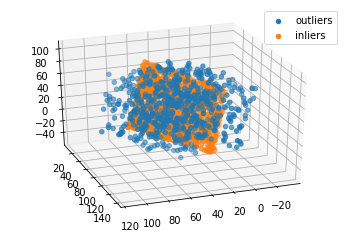

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[n:n+m, 0], points[n:n+m, 1], points[n:n+m, 2], label='outliers')
ax.scatter(points[0:n, 0], points[0:n, 1], points[0:n, 2], label='inliers')
ax.legend()
ax.view_init(30, 70) 

Iteration to find RANSAC plane. The plane parameters (a, b, c, d) are calculated using homogenouos coordinates. 

In [46]:
if points.shape[1] < 4:
    points = np.c_[points, np.full((n+m, 1), 1)]    # change to homogenouos coord
best_n = 0          # number of points on the best plane so far
best_i = 0          # iteration index of best plane so far
best_inliers = np.array([]) # indices of inliers of the best plane so far
for i in np.arange(iterations):
    # select three random points
    l = []  # list of random indices for points
    while len(l) != 3:
        l = list(set(np.random.randint(n+m, size=3))) # remove repeated random integers
    pp = points[l]  # randomly selected points
    # plane equation from the three points using homogenouos coordinates
    a = np.linalg.det(pp[:,1:])
    b = -np.linalg.det(pp[:, [0, 2, 3]])
    c = np.linalg.det(pp[:, [0, 1, 3]])
    d = -np.linalg.det(pp[:, 0:3])
    plane = np.array([a, b, c, d])
    plane = plane / np.sqrt(plane[0:3].dot(plane[0:3]))   # normal to unit vector
    # select close points
    inliers = points[np.abs(np.dot(points, plane)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers[:,:3].copy()
        best_plane = plane.copy()
print(f'Best solution after {best_i} iterations, {best_n} points on plane: {best_plane}')

Best solution after 9 iterations, 1000 points on plane: [ -0.43288269   0.69462338   0.57455282 -50.01105359]


*Try* to run the block above several times and check best_i and best_n to fine tune the number interations. Do you get the same result if you repeat the calculation?

There is a formula to estimate the neccesary iteration number of RANSAC algorithm:

$n_{try} = \frac {log(1-p)} {log(1 - (inliers / all)^3)}$

where:
    p - the needed probability (e.g. 0.99)

    inliers - the number of inliers

    all - total number of points

    n_try - the number of iteration

Let's apply the formula to our previous example!

In [47]:
from math import log
p = 0.99
n_try = int(log(1 - p) / log(1 - (n / (n + m))**3))
print(n_try)

16


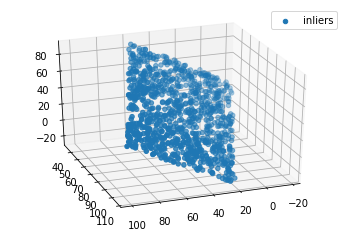

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(best_inliers[:, 0], best_inliers[:, 1], best_inliers[:, 2], label='inliers')
#ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='outliers')
ax.legend()
ax.view_init(30, 70)

**Tasks**

- Run the RANSAC iteration block above and check *best_i* and *best_n* to check the neccessary interation number.
- Turn the RANSAC iteration into a function.
- Try the RANSACRegression function of sklearn.linear_model

# Find multiple planes in a point cloud

Mostly we are looking not for a single plane but the simplified model of the object in the point cloud. In this sample we try to find the faces (linear) of a geometrical object.

![seqrangif](https://raw.githubusercontent.com/leomariga/pyRANSAC-3D/master/doc/plano.gif)

To manage point clouds there are several Python packages like  [Open3D](http://www.open3d.org), [PDAL](https://pdal.io), [lidR](https://r-lidar.github.io/lidRbook/index.html), [pyntcloud](https://pyntcloud.readthedocs.io/en/latest/), etc.

In the following we will use [Open3D](http://www.open3d.org), which can handle RANSAC in addition to point clouds.

At first install Open3D module! It may take few minutes.

In [ ]:
!pip install open3d -q

     |████████████████████████████████| 408.6 MB 35 kB/s 
     |████████████████████████████████| 1.1 MB 22.8 MB/s 
     |████████████████████████████████| 4.3 MB 24.3 MB/s 
     |████████████████████████████████| 8.7 MB 20.4 MB/s 
     |████████████████████████████████| 596 kB 27.7 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 428 kB 36.8 MB/s 
     |████████████████████████████████| 342 kB 31.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 130 kB 38.6 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 561 kB 47.6 MB/s 
     |████████████████████████████████| 133 kB 45.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 re

A small point cloud of a building will be used, let's download it from GitHub!

In [ ]:
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/house.pcd -O sample_data/house.pcd

Find *n_planes* number of planes having most of the points.

2208 points left from 7190


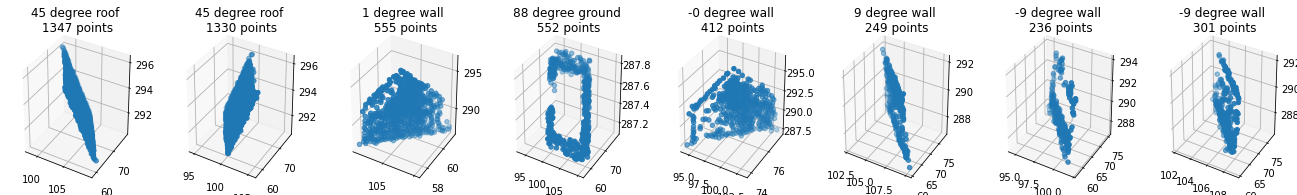

In [ ]:
import open3d as o3d
import numpy as np

def label(ang):
    """ return roof/wall/ground label from angle of normal to horizontal """
    label = '???'
    if abs(ang < 15):
        label = 'wall'
    elif 80 < abs(ang) < 100:
        label = 'ground'
    elif 35 < abs(ang) < 55:
        label = 'roof'
    return label

n_planes = 8
tol = 0.1           # tolerance distance from plane
n_points = 3        # number of random points
iterations = 300
# load point cloud
pc = o3d.io.read_point_cloud('sample_data/house.pcd')
n_orig = len(pc.points)
pc_orig = pc.select_by_index([], invert=True)   # make a copy of original
planes = []     # list of result planes
fig = plt.figure(figsize=(23, 3))

i = 0
while i < n_planes:
    plane, inliers = pc.segment_plane(tol, n_points, iterations)
    angle = atan2(plane[2], hypot(plane[0], plane[1])) * 180. / pi  # angle of normal from horizontal
    plane_pc = pc.select_by_index(inliers)
    o3d.io.write_point_cloud('sample_data/plane_' + str(i) + '.pcd', plane_pc) # export planes
    ax = fig.add_subplot(1, n_planes, i+1, projection='3d')
    ax.set_title(f'{angle:.0f} degree {label(angle)}\n {len(inliers)} points')
    xyz = np.asarray(plane_pc.points)
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    #ch = plane_pc.compute_convex_hull()
    planes.append([plane, plane_pc])
    pc = pc.select_by_index(inliers, invert=True)   # rest of the point cloud
    i += 1
print(f'{len(pc.points)} points left from {n_orig}')

**Let's display the result!**

In [ ]:
data = []
colors = ['red', 'blue', 'green', 'cyan', 'yellow', 'magenta', 'brown', 'orange']
for i, pp in enumerate(planes):
    xyz = np.asarray(pp[1].points)
    data.append(go.Scatter3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], mode='markers',
                             marker=dict(size=1, color=colors[i % len(planes)])))
fig = go.Figure(data=data)
fig.update_layout(scene=dict(aspectmode='manual', aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    width=700, margin=dict(r=20, b=10, l=10, t=10))
fig.update_layout(showlegend=False)
fig.show()

**Tasks for practice**

*   Change the parameters (increase/decrease noise/tolerance/iteration count/etc) run and compare the results.
*   Create a command line ready version
*   Try other modules (like [pyRANSAC-3D](https://leomariga.github.io/pyRANSAC-3D/api-documentation/circle/)) to find different shapes that fits into a part of a point cloud.

